<a href="https://colab.research.google.com/github/alidoukoure/IA_Kill_We_BA/blob/main/Copie_de_Fruit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pickle
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision import transforms, datasets
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/content/archive (12).zip

In [ ]:
# Upload kaggle.jason
# please follow this link incase not aware: https://www.kaggle.com/general/74235
from google.colab import files
files.upload()

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/moltean/fruits'
od.download(dataset_url)

Saving kaggle.json to kaggle (2).json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./fruits" (use force=True to force download)


Avant de lancer une exploration, le jeu de données doit être chargé dans un DataLoader. Nous utilisons ImageFolder de PyTorch pour charger les images dans le DataLoader.

In [ ]:
data_dir = '/content/fruits/fruits-360_dataset/fruits-360/'

train_dataset = ImageFolder(data_dir + "Training", transform=ToTensor())

test_dataset = ImageFolder(data_dir + "Test", transform=ToTensor())

№3 : Explorer le jeu de données
Q : Combien d'images contient l'ensemble de données d'entraînement et de test ?

In [ ]:
dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: /content/fruits/fruits-360_dataset/fruits-360/Training
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 22688
    Root location: /content/fruits/fruits-360_dataset/fruits-360/Test
    StandardTransform
Transform: ToTensor()


Q : Combien de classes de sortie le jeu de données contient-il ?**texte en gras** texte en gras

In [ ]:
# Accesssing the classes
data_dir = '/content/fruits/fruits-360_dataset/fruits-360/'

# print(os.listdir(data_dir))
classes = os.listdir(data_dir + "Training")
print(f'Total Number of Classe {len(classes)}')
print(f'Classes Names: {classes}')

Total Number of Classe 131
Classes Names: ['Kiwi', 'Banana Red', 'Pepino', 'Eggplant', 'Grape White 4', 'Cantaloupe 1', 'Tomato Cherry Red', 'Apricot', 'Tomato Maroon', 'Hazelnut', 'Papaya', 'Apple Braeburn', 'Corn Husk', 'Tomato 3', 'Grapefruit Pink', 'Melon Piel de Sapo', 'Grape White', 'Tomato Heart', 'Nectarine', 'Plum 2', 'Apple Pink Lady', 'Guava', 'Limes', 'Pepper Red', 'Cherry 2', 'Apple Red Yellow 1', 'Pomegranate', 'Cucumber Ripe 2', 'Nut Pecan', 'Walnut', 'Onion Red', 'Pineapple', 'Apple Red Delicious', 'Tomato Yellow', 'Pear', 'Grape White 2', 'Grapefruit White', 'Grape Pink', 'Grape White 3', 'Apple Granny Smith', 'Pear Red', 'Apple Crimson Snow', 'Apple Golden 2', 'Tomato 4', 'Pepper Orange', 'Onion White', 'Mandarine', 'Apple Red 2', 'Watermelon', 'Potato White', 'Lemon', 'Corn', 'Peach 2', 'Cactus fruit', 'Granadilla', 'Pineapple Mini', 'Strawberry Wedge', 'Potato Red Washed', 'Tomato 1', 'Cherry Wax Yellow', 'Huckleberry', 'Orange', 'Pear Kaiser', 'Quince', 'Nut Forest

**Quelle est la forme d'un tenseur d'image à partir du jeu de données ?**

In [ ]:
img, label = train_dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 100, 100])

**Imprimons un exemple d'image avec sa classe et son étiquette.**

Label (numeric): 0
Label (textual): Kiwi


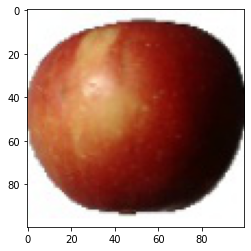

In [ ]:
img, label = train_dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

 **Pouvez-vous déterminer le nombre d'images appartenant à chaque classe ?**

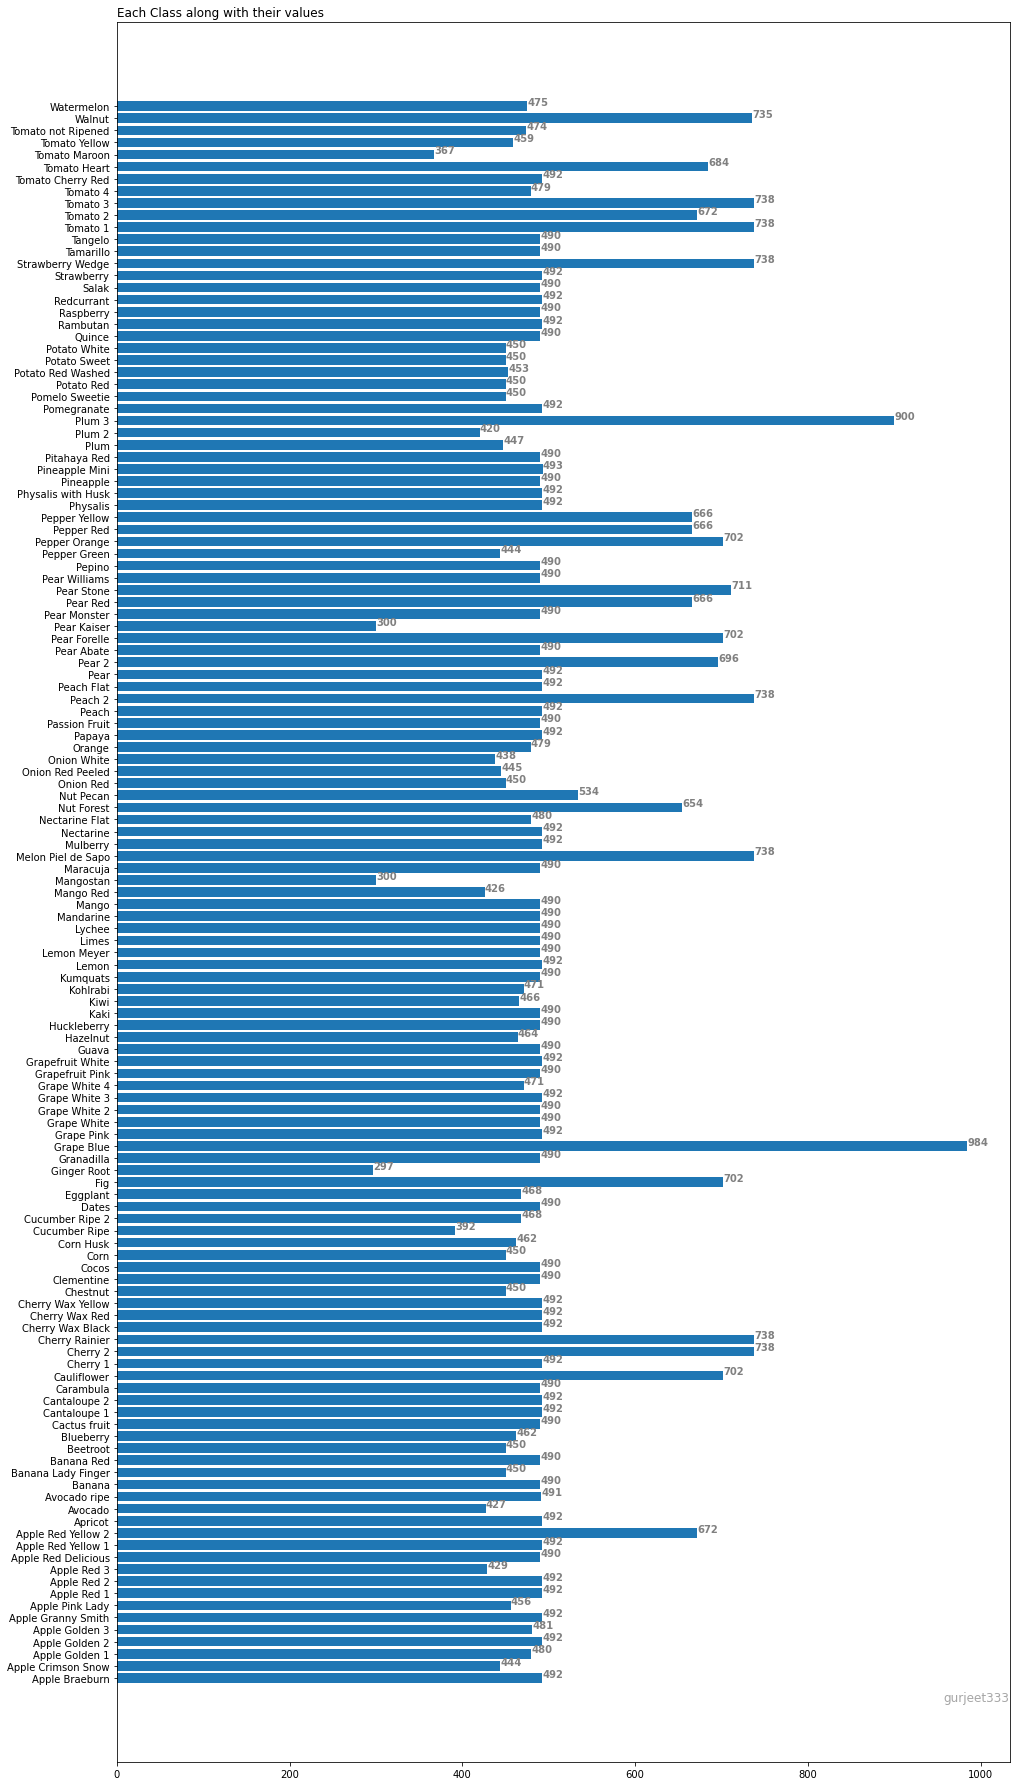

In [ ]:
dataset_size = len(train_dataset)
classes = train_dataset.classes
num_classes = len(train_dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = train_dataset[i]
    img_dict[classes[label]] += 1


## Plotting classes along with images info

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize =(16, 32))

ax.barh(list(img_dict.keys()), list(img_dict.values()))



# Add Plot Title
ax.set_title('Each Class along with their values',
             loc ='left', )

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Text watermark
fig.text(0.9, 0.15, 'gurjeet333', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
plt.show()

#### Appliquer l'augmentation des données
**Construire des transformations de données**
Nous allons d'abord écrire la fonction de transformation afin que l'augmentation des données puisse être implémentée

In [ ]:
# Data transforms (data augmentation)
train_tfms = tt.Compose([
                         tt.RandomCrop(100, padding=4, padding_mode='reflect'), 
                         tt.Resize((100,100)),
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 

                         ])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Resize((100,100)),
                         ])

N'hésitez pas à essayer des paramètres supplémentaires comme tt.RandomRotate, tt.RandomResized, tt.ColorJitter (je les ai ajoutés dans le code)

Application des transformations au jeu de données
La transformation que nous construisons doit être appliquée aux ensembles de données de formation et de test. Remarque : nous n'appliquons pas l'augmentation des données dans le jeu de données de test.

In [ ]:
dataset = ImageFolder(data_dir + "/Training", transform=train_tfms)

Testing = ImageFolder(data_dir + "/Test", transform=valid_tfms)

#### **Fractionner le jeu de données**
Nous utiliserons un ensemble de validation de 20 % de l'ensemble de formation. Pour nous assurer que nous obtenons le même ensemble de validation à chaque fois, nous allons définir le générateur de nombres aléatoires de PyTorch sur une valeur de départ de 43.

In [ ]:
torch.manual_seed(43)
val_size = round(len(dataset) * 0.2)
train_size = round(len(dataset) - val_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(54154, 13538)

In [ ]:
batch_size=400

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

#### **№5 : Accéder aux échantillons**
Visualisons un lot de données à l'aide de la fonction d'assistance make_grid de Torchvision.

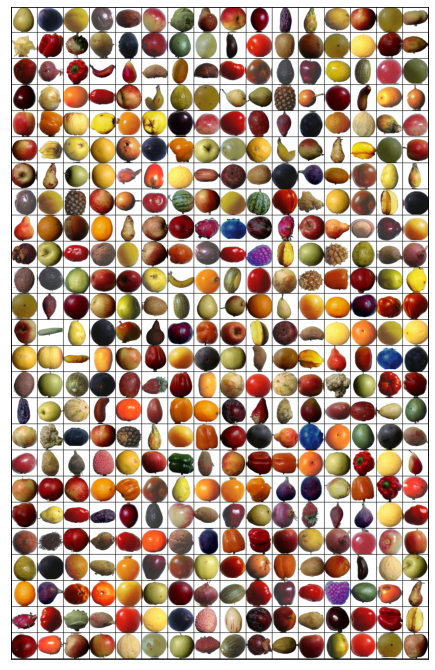

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

Pouvez-vous étiqueter toutes les images en les regardant ? Essayer d'étiqueter manuellement un échantillon aléatoire de données est un bon moyen d'estimer la difficulté du problème et d'identifier les erreurs d'étiquetage, le cas échéant.

## **№6 : Accéder au GPU**
Vous pouvez utiliser une unité de traitement graphique (GPU) pour former vos modèles plus rapidement si votre plate-forme d'exécution est connectée à un GPU fabriqué par NVIDIA. Suivez ces instructions pour utiliser un GPU sur la plate-forme de votre choix :

Google Colab : utilisez l'option de menu "Runtime > Change Runtime Type" et sélectionnez "GPU" dans la liste déroulante "Hardware Accelerator".

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Maintenant, je charge les chargeurs de train et de validation sur GPU à l'aide de la DeviceDataLoaderfonction

In [ ]:
device = get_default_device()
device

train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

# **№7 : Configurer le modèle**
**Configuration de la fonction de précision et de la classe de base d'image**

Les deux sont des fonctions génériques et ne nécessitent aucune modification, quels que soient les jeux de données. Ce sont des fonctions d'assistance pour calculer la précision et implémentent la fonction de perte pour calculer la perte d'apprentissage et de validation du modèle.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

**Mise en œuvre de la normalisation par lots et de l'abandon**
Nous utilisons nn.Squentialpour enchaîner les couches du réseau de neurones. J'ai ajouté des commentaires dans le code pour simplifier la compréhension. Remarque - Ici, j'ai implémenté la normalisation par lots en utilisant nn.BatchNorm2dle module à la fin de chaque couche.

In [ ]:
class Fruit360CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size=3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16 X 50 X 50

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32 X 25 X 25

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, 5), # 64 X 5 X 5

            nn.Flatten(), 
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64*5*5, 131))
        
    def forward(self, xb):
        xb = self.network[0:13](xb)
        xb = xb.view(xb.size(0), -1)  # flatten the tensor
        xb = self.network[13:](xb)
        return xb

new_model = Fruit360CnnModel()
new_model










"""
The adjustments made include changing the kernel size of the convolutional layers in the Fruit360CnnModel to 3, and adjusting the model initialization to include these changes. Additionally, the ImageClassificationBase code was left unchanged.
Q:?
quel est l'interet d'utiliser sequential?
L'utilisation de nn.Sequential dans PyTorch permet de définir rapidement des modèles de réseaux de neurones en séquentiel enchainant les couches de manière linéaire.

Au lieu de définir chaque couche de manière individuelle, on peut utiliser la fonction nn.Sequential pour créer une séquence linéaire de couches en les passant en tant qu'arguments. Cela permet de gagner du temps et de rendre le code plus lisible.

En utilisant nn.Sequential, les entrées sont passées de couche en couche, et la sortie de chaque couche devient l'entrée de la couche suivante, sans avoir à spécifier explicitement les tenseurs d'entrée et de sortie à chaque étape.

Q:?
donc potentiellement plus rapide?
Oui, l'utilisation de Sequential peut être plus rapide que de créer un modèle à partir de couches individuelles en raison de la manière dont il gère les connexions entre les couches et la manière dont il effectue le calcul. Cela peut rendre le processus d'entraînement plus rapide et plus efficace, en particulier pour les réseaux de neurones plus simples. Cependant, pour les modèles plus complexes, il peut être préférable de construire le modèle couche par couche pour avoir plus de contrôle sur l'architecture du réseau.
"""





"\nThe adjustments made include changing the kernel size of the convolutional layers in the Fruit360CnnModel to 3, and adjusting the model initialization to include these changes. Additionally, the ImageClassificationBase code was left unchanged.\nQ:?\nquel est l'interet d'utiliser sequential?\nL'utilisation de nn.Sequential dans PyTorch permet de définir rapidement des modèles de réseaux de neurones en séquentiel enchainant les couches de manière linéaire.\n\nAu lieu de définir chaque couche de manière individuelle, on peut utiliser la fonction nn.Sequential pour créer une séquence linéaire de couches en les passant en tant qu'arguments. Cela permet de gagner du temps et de rendre le code plus lisible.\n\nEn utilisant nn.Sequential, les entrées sont passées de couche en couche, et la sortie de chaque couche devient l'entrée de la couche suivante, sans avoir à spécifier explicitement les tenseurs d'entrée et de sortie à chaque étape.\n\nQ:?\ndonc potentiellement plus rapide?\nOui, l'ut

**Mise en œuvre de la perte de poids, de l'écrêtage des dégradés et de l'optimiseur Adam pendant l'entraînement**

In [ ]:
@torch.no_grad()

def evaluate(new_model, val_loader):
    new_model.eval()
    outputs = [new_model.validation_step(batch) for batch in val_loader]
    return new_model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, new_model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(new_model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        new_model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = new_model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(new_model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(new_model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        new_model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Define optimizer and loss function
from torch.optim import Adam
optimizer = Adam(new_model.parameters(), lr=0.001)
loss_fn = F.cross_entropy

# Define training function
def train(epochs, train_loader, val_loader, new_model, optimizer, loss_fn):
    for epoch in range(epochs):
        # Training Phase
        train_loss = 0
        for batch in train_loader:
            images, labels = batch
            outputs = new_model(images)
            loss = loss_fn(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            nn.utils.clip_grad_norm_(new_model.parameters(), max_norm=1.0) # gradient clipping
            optimizer.step()
            optimizer.zero_grad()
        train_loss /= len(train_loader)

        # Validation phase
        val_loss = 0
        val_acc = 0
        for batch in val_loader:
            images, labels = batch
            outputs = new_model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            acc = accuracy(outputs, labels)
            val_acc += acc
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Print progress
        print("Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, epochs, train_loss, val_loss, val_acc))


In [ ]:
# Moving the new_model to GPU
new_model = to_device(new_model, device)
new_model

Fruit360CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.3, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=1600, out_features=131, bias=True)


Le modèle semble fonctionner très mal avant l'entraînement. Comme observé ci-dessous, la précision du modèle est inférieure à 1 %, car le modèle tente de deviner au hasard la sortie.

In [ ]:

os.environ['WANDB_CONSOLE'] = 'off'

history = [evaluate(new_model, valid_dl)]
history

[{'val_loss': 4.8771467208862305, 'val_acc': 0.0055944123305380344}]

## **№8 : Formation du modèle et analyse des résultats Configuration des paramètres avant l'entraînement**

In [ ]:
epochs = 4
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

**Exécution du modèle sur 4 époques**

In [ ]:
%%time

os.environ['WANDB_CONSOLE'] = 'off'

history += fit_one_cycle(epochs, max_lr, new_model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 1.2861, val_loss: 6.3206, val_acc: 0.3169
Epoch [1], train_loss: 0.1396, val_loss: 0.1314, val_acc: 0.9568
Epoch [2], train_loss: 0.0131, val_loss: 0.0027, val_acc: 0.9998
Epoch [3], train_loss: 0.0047, val_loss: 0.0012, val_acc: 0.9999
CPU times: user 15.1 s, sys: 9.56 s, total: 24.7 s
Wall time: 4min 33s


Nous avons obtenu une très bonne précision sous 4 époques avec 4 minutes. C'est la puissance de toutes les techniques que nous avons mises en œuvre.

**Précision vs nombre d'époques**

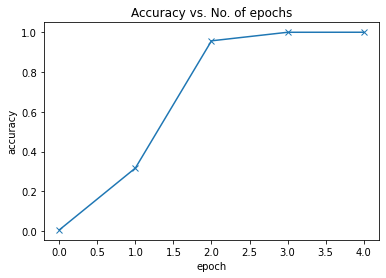

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

Comme les pertes de formation et de validation ne divergent pas, elles convergent, cela montre que nous ne surajustons pas notre modèle

**Taux d'apprentissage avec lot non**

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

Comme prévu, le taux d'apprentissage commence à une valeur faible, et augmente progressivement pendant 30 % des itérations jusqu'à une valeur maximale de 0,01, puis diminue progressivement jusqu'à une valeur très faible.

## **№9 : Prédictions**
Testons la prédiction du modèle sur le jeu de données de test

In [ ]:
test_tfms = tt.Compose([tt.Resize((100, 100)), 
                        tt.ToTensor()])

In [ ]:
test_dataset = ImageFolder(data_dir + "Test", transform=test_tfms)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(new_model, test_loader)
result

{'val_loss': 0.06084120646119118, 'val_acc': 0.9878508448600769}

La précision de la validation est supérieure à 98 % , nous écrivons une fonction d'assistance qui prend une image et s'applique au modèle

Nous testons maintenant les prédictions sur des exemples d'images

Label: Apple Braeburn Predicted: Apple Braeburn


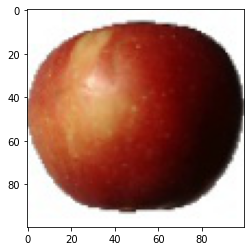

In [ ]:
def predict_image(img, new_model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from new_model
    yb = new_model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

# Test the function on a sample image
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], 'Predicted:', predict_image(img, new_model, dataset.classes))

NB:

**The unsqueeze(0) method** 

is a PyTorch tensor method that adds a new dimension at the specified position (in this case, at index 0).

For example, suppose you have a tensor t with shape (3,). If you call t.unsqueeze(0), it will return a new tensor with shape (1, 3). The original tensor t is essentially "expanded" along a new dimension at the beginning of the tensor.

In the context of neural networks, this method is often used to add a batch dimension to a single data point. For instance, if you have a single image tensor with shape (3, 224, 224) (representing 3 channels and a 224x224 pixel resolution), you can add a batch dimension by calling unsqueeze(0) on the tensor, which will result in a tensor with shape (1, 3, 224, 224). This is often required for passing a single image through a network that is designed to process batches of images.


**The permute() method** 

in PyTorch is used to change the order of dimensions in a tensor. In the context of computer vision, an image tensor is usually represented as a 3D tensor with dimensions (channels, height, width), where "channels" refers to the color channels of the image (e.g. 3 for RGB images), and "height" and "width" are the dimensions of the image in pixels.

The permute(1, 2, 0) method call rearranges the dimensions of the image tensor from (channels, height, width) to (height, width, channels), which is a more natural format for displaying images with the matplotlib library.

Specifically, permute(1, 2, 0) swaps the second dimension (height) with the third dimension (width), and moves the original third dimension (channels) to the new first dimension. The resulting tensor can be thought of as a 2D matrix where each element corresponds to a pixel in the image, and the channels are represented as "layers" of the matrix.

Label: Apple Braeburn Predicted: Apple Braeburn
Label: Apple Braeburn Predicted: Apple Braeburn


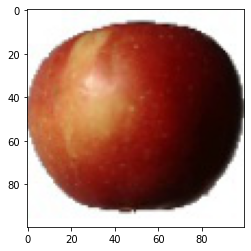

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], 'Predicted:', predict_image(img, new_model, dataset.classes))

img, label = test_dataset[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], 'Predicted:', predict_image(img, new_model, dataset.classes))

Label: Apple Golden 2 , Predicted: Apple Golden 2


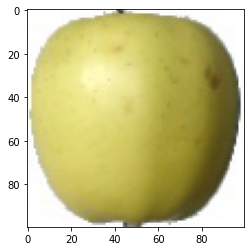

In [ ]:
img, label = test_dataset[512]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, new_model, dataset.classes))

Label: Banana Red , Predicted: Banana Red


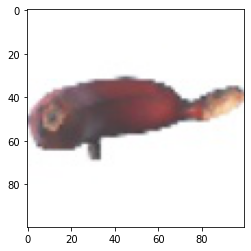

In [ ]:
img, label = test_dataset[3015]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, new_model, dataset.classes))

## **№10 : Résumé**
Voici un résumé des différentes techniques utilisées dans ce tutoriel pour améliorer les performances de notre modèle et réduire le temps d'apprentissage :

 - **Augmentation des données** : nous avons appliqué des transformations aléatoires lors du chargement des images à partir de l'ensemble de données d'entraînement. Plus précisément, nous allons remplir chaque image de 4 pixels, puis prendre un recadrage aléatoire de taille 100 x 100 pixels, puis retourner l'image horizontalement avec une probabilité de 50 %.

 - **Normalisation par lots :** Après chaque couche convolutive, nous avons ajouté une couche de normalisation par lots, qui normalise les sorties de la couche précédente. Ceci est quelque peu similaire à la normalisation des données, sauf qu'il est appliqué aux sorties d'une couche, et que la moyenne et l'écart type sont des paramètres appris.

 - **Planification du taux d'apprentissage :** Au lieu d'utiliser un taux d'apprentissage fixe, nous utiliserons un planificateur de taux d'apprentissage, qui modifiera le taux d'apprentissage après chaque lot de formation. Il existe de nombreuses stratégies pour faire varier le taux d'apprentissage pendant la formation, et nous avons utilisé la «politique du taux d'apprentissage en un cycle».

 - **Décroissance de poids :** Nous avons ajouté la décroissance de poids à l'optimiseur, encore une autre technique de régularisation qui empêche les poids de devenir trop grands en ajoutant un terme supplémentaire à la fonction de perte.

 - **Écrêtage des dégradés :** nous avons également ajouté l'écrêtage des dégradés, qui permet de limiter les valeurs des gradients à une petite plage afin d'éviter des changements indésirables dans les paramètres du modèle en raison de valeurs de gradient importantes pendant l'entraînement.
Optimiseur Adam : Au lieu de SGD (descente de gradient stochastique), nous avons utilisé l'optimiseur Adam qui utilise des techniques telles que l'élan et les taux d'apprentissage adaptatifs pour un entraînement plus rapide. Il existe de nombreux autres optimiseurs pour choisir le format et expérimenter.

#### **№11 : Model Saving**

In [ ]:
# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(new_model, open(filename, 'wb'))

**In PyTorch, state_dict() is a method**

that returns a dictionary object containing the current state of the model. The state of the model includes all its learnable parameters (weights and biases) and any other persistent buffers (such as running averages) that are used during inference.

The state_dict() method is used to save and load model weights during training and inference. It is a common practice to save the model's state dict to a file after training, so that it can be loaded later for further use or inference. By default, the state dict does not contain any information about the model architecture, so it is important to save the architecture information separately to be able to load the model properly later.


Saving the whole model using torch.save(model, '/content/fruits/model2802.pth') is a straightforward way to save the model, but it may not always be the most efficient option. This method saves the entire model object, including the model architecture, weights, and all other attributes. If the model is large or has a lot of parameters, it can take up a lot of disk space and may also take a long time to load later.

A better approach would be to save only the model state dictionary using torch.save(model.state_dict(), '/content/fruits/model2802.pth'). This method only saves the model's weights and biases, which are usually the most important parts of the model. It can save disk space and load faster later on when we want to load the model.

However, note that if we save only the state dictionary, we need to define and initialize the model architecture again before loading the state dictionary.

In [ ]:
torch.save(new_model, '/content/fruits/model0103.pth')

In [ ]:
model_scripted = torch.jit.script(new_model)
model_scripted.save('/content/fruits/new_model.pt')

RuntimeError: ignored

In [ ]:
torch.save(new_model.state_dict(), '/content/fruits/modelstate_dict.pth')

In [ ]:
#model = MyModelClass(*args, **kwargs)  # create an instance of the model class
#model.load_state_dict(torch.load(PATH, map_location=device))
# In Django Model:
#output = model(input)



#### **№12 : Références**
Mon travail est disponible sur:
 - https://colab.research.google.com/drive/11W_na8KQXtjSmX7n-JkrWD04xheuMg2x#scrollTo=oaVx7TSxFuRx

 - https://web.eecs.umich.edu/~justincj/teaching/eecs442/WI2021/colab.html

 - https://medium.com/geekculture/pytorch-training-fruit-360-classifier-under-5-mins-23153b46ec88
 - https://jovian.ai/hargurjeet/fruit-360-classification-v1-2204a
 - https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-5-data-augmentation-regularization-and-resnets
 - https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
 - https://androidkt.com/how-to-apply-gradient-clipping-in-pytorch/
 - https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9
 - https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
 - https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
 - https://neptune.ai/blog/data-augmentation-in-python

# Nouvelle section

# Nouvelle section